In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from model import Net
from train import train
from test import test
from config import ModelConfig

In [4]:
# View model config
args = ModelConfig()
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


In [5]:
transform = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)),
     transforms.RandomAffine((-5,5), translate=(0.1,0.1), scale=(0.9,1.1), shear=None, resample=False)
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1343: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


torch.Size([4, 3, 32, 32])
 ship  bird   cat   dog


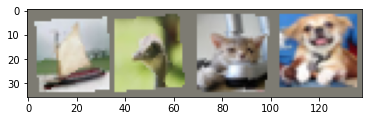

In [6]:
# functions to show an image

def imshow(img):
    #(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


In [8]:
temp = Net(args).to(device)
summary(temp, 
        (3, 32, 32),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             ReLU-14           [-1, 64,

/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net5'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.7526127099990845 Batch_id=12499 Accuracy=38.33: 100%|██████████| 12500/12500 [00:50<00:00, 249.45it/s] 

length of Average loss 12500, length of Average accuracy 12500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3282, Accuracy: 5442/10000 (54.42%)

EPOCH: 2


Loss=0.8048476576805115 Batch_id=12499 Accuracy=51.42: 100%|██████████| 12500/12500 [00:50<00:00, 248.20it/s] 

length of Average loss 25000, length of Average accuracy 25000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2899, Accuracy: 6227/10000 (62.27%)

EPOCH: 3


Loss=1.4175455570220947 Batch_id=12499 Accuracy=57.57: 100%|██████████| 12500/12500 [00:50<00:00, 248.60it/s] 

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2813, Accuracy: 6485/10000 (64.85%)

EPOCH: 4


Loss=1.0609259605407715 Batch_id=12499 Accuracy=56.82: 100%|██████████| 12500/12500 [00:50<00:00, 249.70it/s]  

length of Average loss 50000, length of Average accuracy 50000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3231, Accuracy: 6278/10000 (62.78%)

EPOCH: 5


Loss=0.9561313986778259 Batch_id=12499 Accuracy=61.40: 100%|██████████| 12500/12500 [00:49<00:00, 250.30it/s]  

length of Average loss 62500, length of Average accuracy 62500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2484, Accuracy: 6731/10000 (67.31%)

EPOCH: 6


Loss=0.1405598670244217 Batch_id=12499 Accuracy=64.43: 100%|██████████| 12500/12500 [00:50<00:00, 250.00it/s]  


length of Average loss 75000, length of Average accuracy 75000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2686, Accuracy: 6916/10000 (69.16%)

EPOCH: 7


Loss=1.1590756177902222 Batch_id=12499 Accuracy=65.73: 100%|██████████| 12500/12500 [00:49<00:00, 250.91it/s]  

length of Average loss 87500, length of Average accuracy 87500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2533, Accuracy: 7071/10000 (70.71%)

EPOCH: 8


Loss=0.9959769248962402 Batch_id=12499 Accuracy=66.35: 100%|██████████| 12500/12500 [00:49<00:00, 251.13it/s]  


length of Average loss 100000, length of Average accuracy 100000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2384, Accuracy: 7191/10000 (71.91%)

EPOCH: 9


Loss=1.5845520496368408 Batch_id=12499 Accuracy=66.61: 100%|██████████| 12500/12500 [00:50<00:00, 247.86it/s]  

length of Average loss 112500, length of Average accuracy 112500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2483, Accuracy: 6875/10000 (68.75%)

EPOCH: 10


Loss=1.2340599298477173 Batch_id=12499 Accuracy=67.46: 100%|██████████| 12500/12500 [00:49<00:00, 251.57it/s]  

length of Average loss 125000, length of Average accuracy 125000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2665, Accuracy: 7270/10000 (72.70%)

EPOCH: 11


Loss=0.8820043802261353 Batch_id=12499 Accuracy=69.22: 100%|██████████| 12500/12500 [00:50<00:00, 249.23it/s]  

length of Average loss 137500, length of Average accuracy 137500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2035, Accuracy: 7370/10000 (73.70%)

EPOCH: 12


Loss=0.6570616960525513 Batch_id=1249 Accuracy=68.86:  10%|█         | 1250/12500 [00:05<00:45, 247.66it/s] 


KeyboardInterrupt: 